

Descripcio


In [88]:
import os
import glob
import json
import random
import datetime
import re
import cv2
import math
from typing import List, Optional, Dict, Any, Tuple

import numpy as np
from pathlib import Path

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader, IterableDataset, TensorDataset
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image

from scipy.stats import ttest_ind

from captum.concept import TCAV, Concept, Classifier
from captum.attr import LayerGradientXActivation, LayerIntegratedGradients
from captum.concept._utils.data_iterator import dataset_to_dataloader, CustomIterableDataset
from captum.concept._utils.common import concepts_to_str


from model.model import Net
from tools import utils, plotting, metrics, model_io, tcav, data


In [89]:

ROOT = r"C:/Users/Dylan/Desktop/TCAV Captum/"          
TOOLS = f"{ROOT}/tools"
MODEL_PY = f"{ROOT}/model/model.py"                 
CKPT_PATH = f"{ROOT}/weights/pesos.pt"                       
CONCEPTS_ROOT = f"{ROOT}/data/concepts"      
RANDOM_POOLS = ["random_pool", "random_pool_2"]
TARGETS_ROOT = f"{ROOT}/data/aixi_shape/val"   
IMG_SIZE = 128
IMG_CHANNELS = 1        
N_EXAMPLES = 128        

import sys, os
sys.path.insert(0, ROOT) 

from tools import utils, data, model_io, plotting, metrics, tcav
import torch, numpy as np
from PIL import Image
from torchvision import transforms

utils.set_seed(0)
device = utils.select_device("cpu")  
print("Device:", device)


Device: cpu


In [43]:

N_CLASSES   = 1
TARGET_CLASS = None

model = model_io.build_model_from_py(
    py_file=MODEL_PY,
    class_name="Net",
    ckpt_path=CKPT_PATH,
    device=device,
    numChannels=IMG_CHANNELS,
    classes=N_CLASSES,
    do_sigmoid=False,        
    size_img=IMG_SIZE,
)


dummy = torch.randn(1, IMG_CHANNELS, IMG_SIZE, IMG_SIZE, device=device)
with torch.no_grad():
    out = model(dummy)
print("Forward OK. Output shape:", tuple(out.shape))
print("TARGET_CLASS:", TARGET_CLASS)


Forward OK. Output shape: (1, 1)
TARGET_CLASS: None


In [44]:
LAYER_NAMES = ["relu3", "relu4", "relu5", "fc3"]


leaves = utils.list_named_layers(model)
print("Example leaf modules:", list(leaves.keys())[:30])


Example leaf modules: ['conv1', 'relu1', 'bn1', 'maxpool1', 'conv2', 'relu2', 'bn2', 'maxpool2', 'conv3', 'relu3', 'bn3', 'maxpool3', 'conv4', 'relu4', 'bn4', 'maxpool4', 'conv5', 'relu5', 'bn5', 'maxpool5', 'fc1', 'dropout1', 'relu6', 'fc2', 'dropout2', 'relu7', 'fc3', 'dropout3', 'relu8', 'fc4']


In [46]:
from typing import Sequence, List, Optional, Union
from captum.concept import Concept
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch, os

class OnlyImageDataset(Dataset):
    def __init__(self, paths, transform, mode="L",
                 device: Optional[Union[str, torch.device]] = None):
        self.paths = list(paths)
        self.transform = transform
        self.mode = mode
        self.device = torch.device(device) if device is not None else None

    def __len__(self): return len(self.paths)

    def __getitem__(self, i):
        img = Image.open(self.paths[i]).convert(self.mode)
        t = self.transform(img).float()       
        if self.device is not None and self.device.type != "cpu":
            
            t = t.to(self.device, non_blocking=True)
        return t

def make_concepts_from_folders(
    concepts_root: str,
    names,
    *,
    img_size: int = 128,
    grayscale: bool = True,
    batch_size: int = 64,
    start_id: int = 0,
    skip_empty: bool = True,
    data_module=None,              
    device: Optional[Union[str, torch.device]] = None,
    limit_per_concept: Optional[int] = None,
    num_workers: int = 0,          
    pin_memory: bool = False,      
) -> List[Concept]:
    assert data_module is not None, "Pass your 'data' module as data_module=..."
    tfm = data_module.default_transform(img_size, grayscale=grayscale)
    mode = "L" if grayscale else "RGB"

    dev = torch.device(device) if device is not None else torch.device("cpu")
    concepts: List[Concept] = []
    skipped = []
    cid = start_id

    for name in names:
        folder = os.path.join(concepts_root, name)
        paths  = data_module.list_images(folder)
        if skip_empty and len(paths) == 0:
            skipped.append(name)
            continue
        if limit_per_concept:
            paths = paths[:limit_per_concept]

        
        ds = OnlyImageDataset(paths, tfm, mode=mode, device=dev if dev.type != "cpu" else None)

        
        loader = DataLoader(
            ds,
            batch_size=batch_size,
            shuffle=True,
            num_workers=num_workers,
            pin_memory=pin_memory if (dev.type == "cpu" and ds.device is None) else False,
        )

        concepts.append(Concept(cid, name, loader))   
        cid += 1

    if skipped:
        print("Skipped empty concept folders:", skipped)
    return concepts


In [47]:

device = utils.select_device("cpu")


all_concepts = data.list_concepts(CONCEPTS_ROOT)
auto_randoms = [c for c in all_concepts if c.lower().startswith("random_pool")]
positive_concepts = [c for c in all_concepts if c not in set(auto_randoms)]




pos_concepts = make_concepts_from_folders(
    CONCEPTS_ROOT, positive_concepts,
    img_size=IMG_SIZE, grayscale=(IMG_CHANNELS==1),
    start_id=0, data_module=data,
    device=device,                 
    limit_per_concept=200,         
    batch_size=64, num_workers=0,
)

start_id_for_randoms = (max([c.id for c in pos_concepts], default=-1) + 1)
rnd_concepts = make_concepts_from_folders(
    CONCEPTS_ROOT, auto_randoms,
    img_size=IMG_SIZE, grayscale=(IMG_CHANNELS==1),
    start_id=start_id_for_randoms, data_module=data,
    device=device,                 
    limit_per_concept=200,
    batch_size=64, num_workers=0,
)


experimental_sets = [[pc, rc] for pc in pos_concepts for rc in rnd_concepts]


In [48]:
experimental_sets

[[Concept(0, 'circle_full'), Concept(29, 'random_pool')],
 [Concept(0, 'circle_full'), Concept(30, 'random_pool_2')],
 [Concept(1, 'circle_half_bottom'), Concept(29, 'random_pool')],
 [Concept(1, 'circle_half_bottom'), Concept(30, 'random_pool_2')],
 [Concept(2, 'circle_half_left'), Concept(29, 'random_pool')],
 [Concept(2, 'circle_half_left'), Concept(30, 'random_pool_2')],
 [Concept(3, 'circle_half_right'), Concept(29, 'random_pool')],
 [Concept(3, 'circle_half_right'), Concept(30, 'random_pool_2')],
 [Concept(4, 'circle_half_top'), Concept(29, 'random_pool')],
 [Concept(4, 'circle_half_top'), Concept(30, 'random_pool_2')],
 [Concept(5, 'circle_quarter_bl'), Concept(29, 'random_pool')],
 [Concept(5, 'circle_quarter_bl'), Concept(30, 'random_pool_2')],
 [Concept(6, 'circle_quarter_br'), Concept(29, 'random_pool')],
 [Concept(6, 'circle_quarter_br'), Concept(30, 'random_pool_2')],
 [Concept(7, 'circle_quarter_tl'), Concept(29, 'random_pool')],
 [Concept(7, 'circle_quarter_tl'), Concept

Local image path: /Users/dylancanning/Desktop/Tcav_Captum/Testing-with-Concept-Activation-Vectors/data/aixi_shape/val/01947.png
LOCAL tensor: (1, 1, 128, 128)


/opt/miniconda3/lib/python3.12/site-packages/captum/_utils/models/linear_model/train.py:409: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  bias_values = torch.FloatTensor([sklearn_model.intercept_]).to(  # type: ignore



[LOCAL] Layer: relu3
  circle_full          rate=1.000
  circle_quarter_tl    rate=1.000
  circle_quarter_tr    rate=1.000
  cross_arm_bottom     rate=1.000
  cross_arm_horizontal rate=1.000
  cross_arm_left       rate=1.000
  cross_arm_right      rate=1.000
  cross_arm_top        rate=1.000
  circle_quarter_br    rate=1.000
  circle_half_bottom   rate=1.000

[LOCAL] Layer: relu4
  circle_full          rate=1.000
  circle_quarter_tl    rate=1.000
  circle_quarter_tr    rate=1.000
  cross_arm_bottom     rate=1.000
  cross_arm_horizontal rate=1.000
  cross_arm_left       rate=1.000
  cross_arm_right      rate=1.000
  cross_arm_top        rate=1.000
  circle_quarter_br    rate=1.000
  circle_half_bottom   rate=1.000

[LOCAL] Layer: relu5
  circle_full          rate=1.000
  circle_quarter_tl    rate=1.000
  circle_quarter_tr    rate=1.000
  cross_arm_bottom     rate=1.000
  cross_arm_horizontal rate=1.000
  cross_arm_left       rate=1.000
  cross_arm_right      rate=1.000
  cross_arm_top 

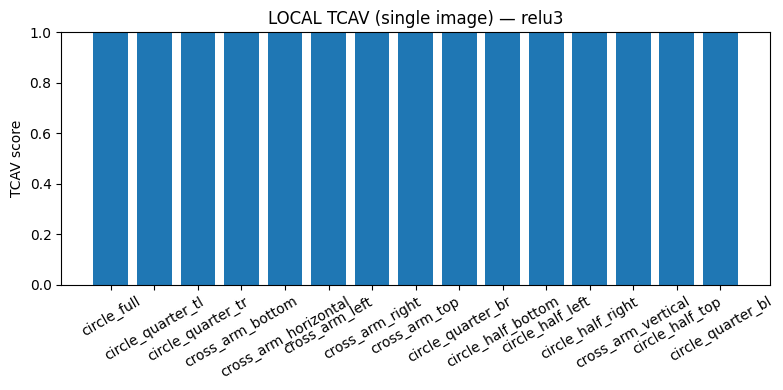

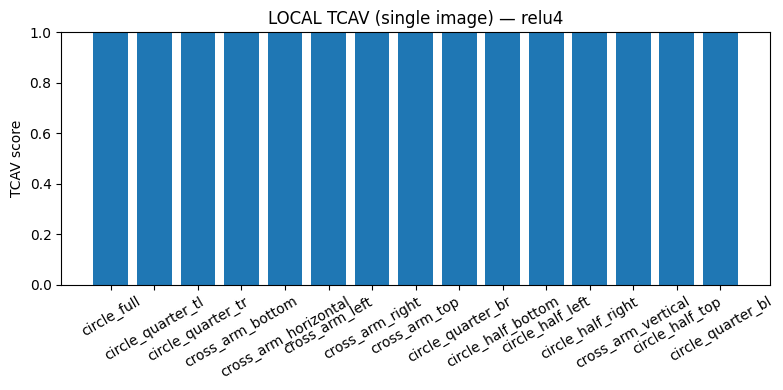

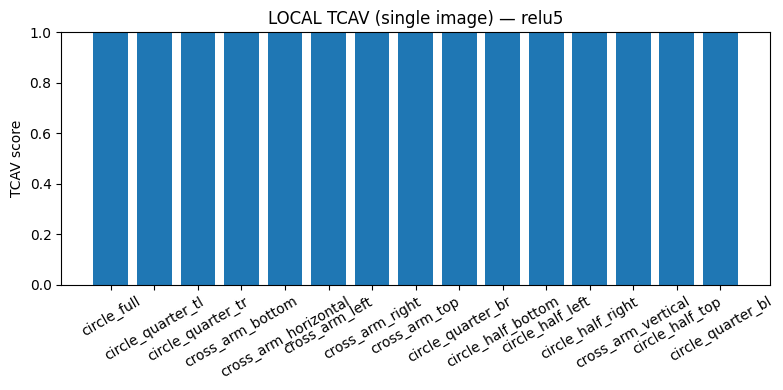

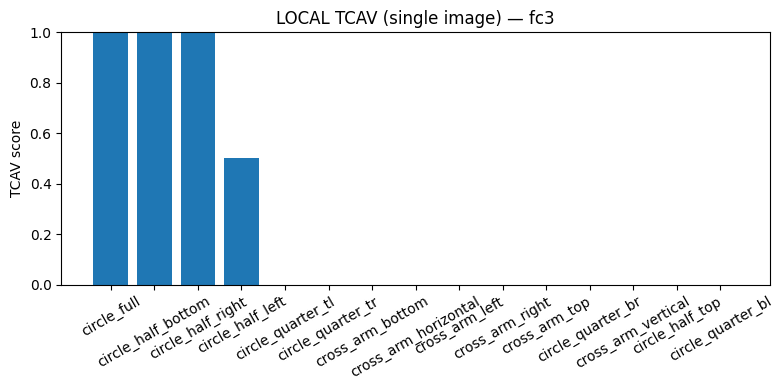

In [ ]:
from captum.concept import TCAV as CaptumTCAV
import inspect

tfm = data.default_transform(IMG_SIZE, grayscale=(IMG_CHANNELS == 1))
tcav_model = model.to("cpu").eval()

LOCAL_IMAGE_PATH = r"" 
def pick_one_image():
    if LOCAL_IMAGE_PATH and os.path.isfile(LOCAL_IMAGE_PATH):
        print(LOCAL_IMAGE_PATH)
        return LOCAL_IMAGE_PATH
    tp = data.list_images(TARGETS_ROOT)
    if tp:
        return str(tp[0])
    if not positive_concepts:
        raise RuntimeError("No positive concept folders available to pick a local image.")
    cand = data.list_images(os.path.join(CONCEPTS_ROOT, positive_concepts[0]))
    if cand:
        return str(cand[0])
    raise RuntimeError("No image found for LOCAL TCAV.")

LOCAL_IMAGE_PATH = pick_one_image()
print("Local image path:", LOCAL_IMAGE_PATH)

if IMG_CHANNELS == 1:
    x_local = tfm(Image.open(LOCAL_IMAGE_PATH).convert("L")).unsqueeze(0)
else:
    x_local = tfm(Image.open(LOCAL_IMAGE_PATH).convert("RGB")).unsqueeze(0)
print("LOCAL tensor:", tuple(x_local.shape))

assert isinstance(experimental_sets, list) and experimental_sets and isinstance(experimental_sets[0], list), \
    "experimental_sets must be a list of [Concept, Concept] pairs."

captum_tcav = CaptumTCAV(model=tcav_model, layers=LAYER_NAMES)

attr_sig = inspect.signature(captum_tcav.layer_attr_method.attribute).parameters
ig_kwargs = {}
if "n_steps" in attr_sig:              
    ig_kwargs["n_steps"] = 3
if "internal_batch_size" in attr_sig:
    ig_kwargs["internal_batch_size"] = 8

raw_local = captum_tcav.interpret(
    inputs=x_local,                      
    experimental_sets=experimental_sets, 
    target=None,                         
    processes=0,                         
    **ig_kwargs                          
)

def summarize_tcav(raw, experimental_sets):
    out = {}
    for exp_key, per_layer in raw.items():
        ci, ri = str(exp_key).split("-")
        ci, ri = int(ci), int(ri)
        c_name = experimental_sets[ci][0].name
        for layer_name, stats in per_layer.items():
            sign = stats.get("sign_count", None)
            if sign is None:
                continue
            pos = float(sign[0].item() if hasattr(sign[0], "item") else sign[0])
            neg = float(sign[1].item() if hasattr(sign[1], "item") else sign[1])
            rate = pos / max(pos + neg, 1.0)
            out.setdefault(layer_name, {}).setdefault(c_name, []).append(rate)
    return {layer: {c: float(np.mean(rates)) for c, rates in d.items()} for layer, d in out.items()}

scores_local = summarize_tcav(raw_local, experimental_sets)

for layer, d in scores_local.items():
    ranked = sorted(d.items(), key=lambda kv: -kv[1])
    print(f"\n[LOCAL] Layer: {layer}")
    for c, rate in ranked[:10]:
        print(f"  {c:20s} rate={rate:.3f}")

plotting.plot_tcav_bars(scores_local, title="LOCAL TCAV (single image)")


In [56]:
import numpy as np
import matplotlib.pyplot as plt

def _val_from(v):
    
    if isinstance(v, dict):
        return float(v.get("mean", np.nan))
    return float(v)

def plot_tcav_heatmaps_per_layer(
    scores_by_layer,                 
    title_prefix="TCAV",
    all_concepts=None,               
    sort="score_desc",               
    annotate=False,                  
    rotate_xticks=60,
    vmin=0.0, vmax=1.0,              
    min_cell_w=0.6,                  
    row_height=1.6                   
):

    
    for layer, concept_dict in scores_by_layer.items():
        if not concept_dict:
            continue

        
        if all_concepts is not None:
            names = list(all_concepts)
            
            extra = [n for n in concept_dict.keys() if n not in names]
            names += extra
        else:
            names = list(concept_dict.keys())

        
        vals = np.array([_val_from(concept_dict.get(n, np.nan)) for n in names], dtype=float)

        
        if sort == "alpha":
            order = np.argsort(np.array(names, dtype=object))
        elif sort == "score_desc":
            
            order = np.argsort(np.nan_to_num(-vals, nan=1e9))
        else:
            order = np.arange(len(names))

        names = [names[i] for i in order]
        vals  = vals[order]

        
        data = vals.reshape(1, -1)

        
        fig_w = max(8.0, min_cell_w * len(names))
        fig_h = row_height

        fig, ax = plt.subplots(figsize=(fig_w, fig_h))
        im = ax.imshow(data, aspect="auto", interpolation="nearest", vmin=vmin, vmax=vmax)

        
        ax.set_yticks([0])
        ax.set_yticklabels([layer])
        ax.set_xticks(np.arange(len(names)))
        ax.set_xticklabels(names, rotation=rotate_xticks, ha="right")

        
        cbar = plt.colorbar(im, ax=ax)
        cbar.set_label("TCAV score")

        
        if annotate:
            for j, v in enumerate(vals):
                if np.isfinite(v):
                    ax.text(j, 0, f"{v:.2f}", ha="center", va="center", fontsize=9)

        ax.set_title(f"{title_prefix} — {layer}")
        plt.tight_layout()
        plt.show()


/var/folders/4p/rs128k3j0_l38wrfg8z1qwj00000gn/T/ipykernel_81735/3338389837.py:80: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


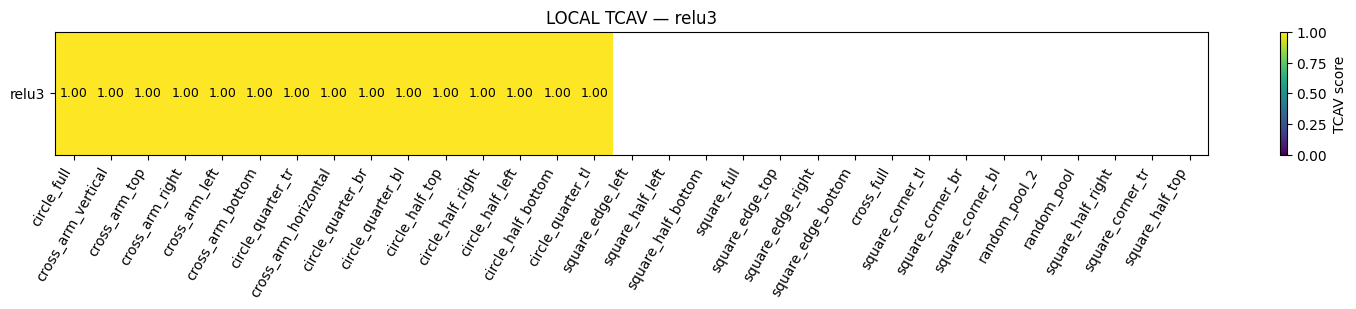

/var/folders/4p/rs128k3j0_l38wrfg8z1qwj00000gn/T/ipykernel_81735/3338389837.py:80: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


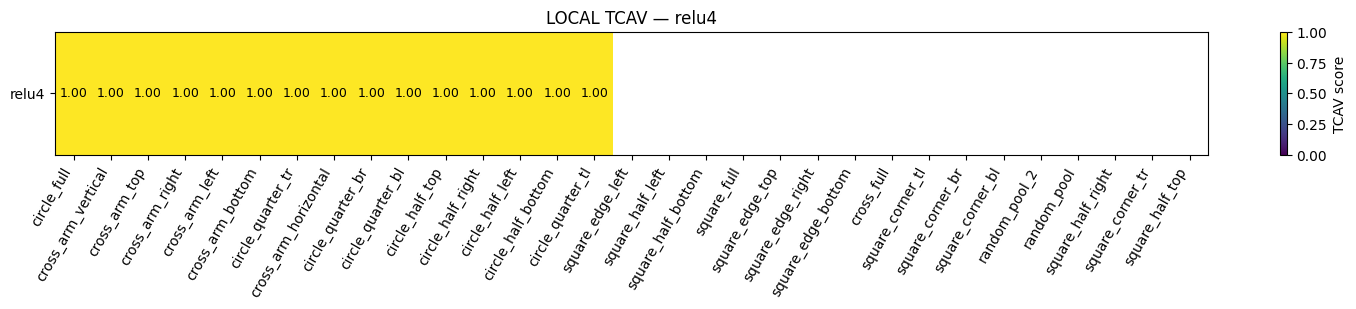

/var/folders/4p/rs128k3j0_l38wrfg8z1qwj00000gn/T/ipykernel_81735/3338389837.py:80: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


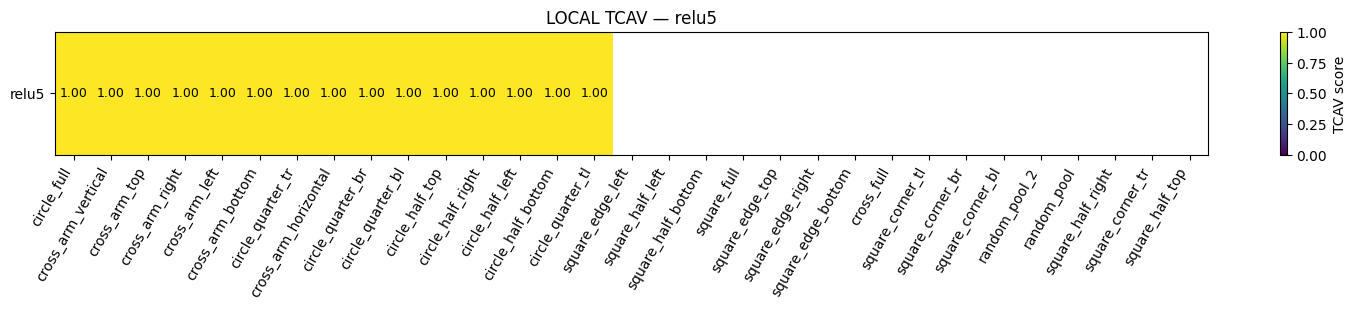

/var/folders/4p/rs128k3j0_l38wrfg8z1qwj00000gn/T/ipykernel_81735/3338389837.py:80: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


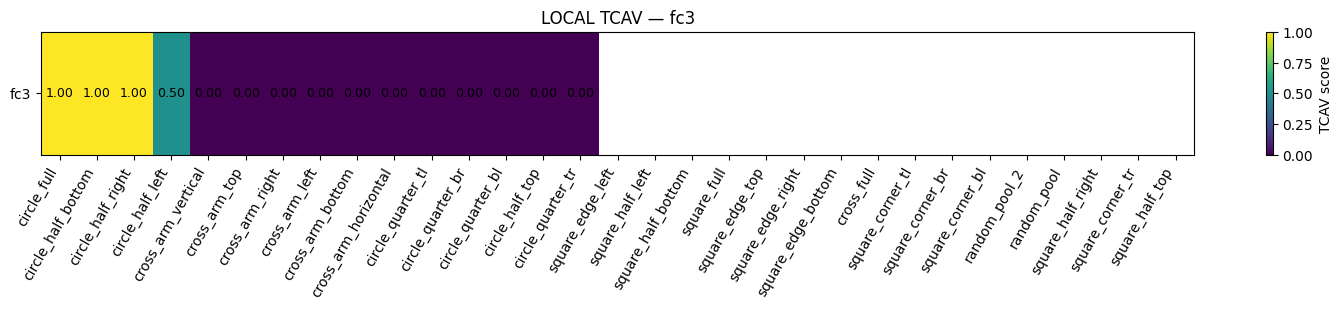

In [40]:
plot_tcav_heatmaps_per_layer(
    scores_local,
    title_prefix="LOCAL TCAV",
    all_concepts=all_concepts,   
    sort="score_desc",
    annotate=True,               
    vmin=0.0, vmax=1.0
)

In [52]:
from importlib import reload
from tools import tcav as tcav_tools
reload(tcav_tools)


from tools import tcav as tcav_tools
LOCAL_IMAGE_PATH = "C:/Users/Dylan/Desktop/TCAV Captum/data/aixi_shape/val/00106.png"

tfm = data.default_transform(IMG_SIZE, grayscale=(IMG_CHANNELS == 1))
x_local = tfm(Image.open(LOCAL_IMAGE_PATH).convert("L")).unsqueeze(0).to(device).float()

clf = tcav_tools.TorchLinearClassifier(device="cpu", epochs=200, lr=0.1, weight_decay=0.0)

lig = LayerIntegratedGradients(tcav_model, None, multiply_by_inputs=False)
mytcav = TCAV(model=tcav_model, layers=LAYER_NAMES, classifier=clf, layer_attr_method=lig)

scores = mytcav.interpret(
    inputs=x_local,                 
    experimental_sets=experimental_sets,
    target=None,
    processes=0,                    
)

In [66]:
def format_float(f):
    return float('{:.3f}'.format(f) if abs(f) >= 0.0005 else '{:.3e}'.format(f))

def plot_tcav_scores_vertical(experimental_sets, tcav_scores, layer_names=None):
    import numpy as np
    import matplotlib.pyplot as plt

    layers = layer_names or LAYER_NAMES
    n_sets = len(experimental_sets)

    
    fig, axes = plt.subplots(n_sets, 1, figsize=(25, 6 * n_sets), constrained_layout=True)
    if n_sets == 1:
        axes = [axes]  

    
    for idx_es, concepts in enumerate(experimental_sets):
        ax = axes[idx_es]

        
        x = np.arange(len(layers))
        n_concepts = len(concepts)
        bar_width = 0.8 / n_concepts

        
        offsets = (np.arange(n_concepts) - (n_concepts - 1) / 2.0) * bar_width

        concepts_key = concepts_to_str(concepts)  

        for i in range(n_concepts):
            
            vals = [format_float(tcav_scores[concepts_key][layer]['sign_count'][i])
                    for layer in layers]
            ax.bar(x + offsets[i], vals, width=bar_width, edgecolor='white',
                   label=concepts[i].name)

        ax.set_title(f"Set {idx_es}", fontweight='bold', fontsize=16)
        ax.set_xticks(x)
        ax.set_xticklabels(layers, fontsize=12, rotation=0)
        ax.set_ylabel('TCAV sign count', fontsize=12)
        ax.legend(fontsize=12)
        ax.grid(axis='y', linestyle=':', alpha=0.4)

    plt.show()


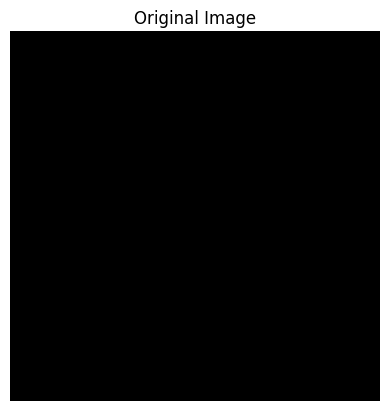

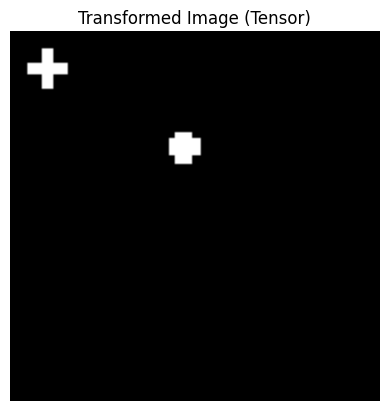

In [73]:
original_img = Image.open(LOCAL_IMAGE_PATH)
plt.imshow(original_img, cmap='gray' if IMG_CHANNELS == 1 else None)
plt.title("Original Image")
plt.axis('off')
plt.show()

transformed_img_tensor = x_local.squeeze(0).cpu().detach()
plt.imshow(transformed_img_tensor.permute(1, 2, 0) if transformed_img_tensor.shape[0] == 3 else transformed_img_tensor.squeeze(), cmap='gray')
plt.title("Transformed Image (Tensor)")
plt.axis('off')
plt.show()

In [68]:
plot_tcav_scores_vertical(experimental_sets=experimental_sets, tcav_scores=scores)

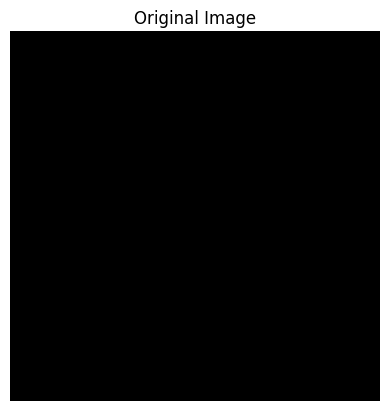

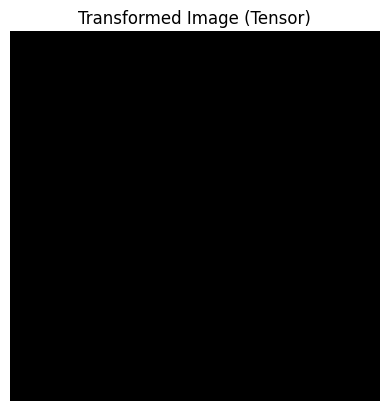

In [70]:
original_img = Image.open(LOCAL_IMAGE_PATH)
plt.imshow(original_img, cmap='gray' if IMG_CHANNELS == 1 else None)
plt.title("Original Image")
plt.axis('off')
plt.show()

transformed_img_tensor = x_local_empty.squeeze(0).cpu().detach()
plt.imshow(transformed_img_tensor.permute(1, 2, 0) if transformed_img_tensor.shape[0] == 3 else transformed_img_tensor.squeeze(), cmap='gray')
plt.title("Transformed Image (Tensor)")
plt.axis('off')
plt.show()